In [1]:
from Helper.Helper_functions import *
from Helper.ml_models import *
from torchvision.utils import save_image
from tqdm import tqdm
from sklearn.utils import class_weight
import torch


2024-05-29 21:02:01.276622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 21:02:01.947846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


kit_image_dir = 'KittiDaten/training/image_2'
kit_annotation_dir = 'KittiDaten/training/semantic'

cit_image_dir = 'CityscapesDaten/images'
cit_annotation_dir = 'CityscapesDaten/semantic'


df = analyse_dataset_GRAY(kit_annotation_dir)
class_distribution_violin_plot(df, output='KittiDaten')
stratified_kfold_and_violin_plot(df, output='KittiDaten',  k=5)


df2 = analyse_dataset_GRAY(cit_annotation_dir)
class_distribution_violin_plot(df2, output='CityscapesDaten')
stratified_kfold_and_violin_plot(df2, output='CityscapesDaten',  k=5)

In [2]:
def analyse_dataset_GRAY(path, classes = None):
    if classes is None:
        classes = {
            7: 'road',
            8: 'sidewalk',
            11: 'building',
            12: 'wall',
            13: 'fence',
            17: 'pole',
            19: 'traffic light',
            20: 'traffic sign',
            21: 'vegetation',
            22: 'terrain',
            23: 'sky',
            24: 'person',
            25: 'rider',
            26: 'car',
            27: 'truck',
            28: 'bus',
            31: 'train',
            32: 'motorcycle',
            33: 'bicycle',
            0: 'unlabeled'
        }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize the counts
    counts = {class_name: [] for class_name in classes.values()}      
    absolute_counts = {class_name: [] for class_name in classes.values()} 
    image_names = []
    
    def count_classes(image_path):
        # Initialize the counts for this image
        image_counts = {class_name: 0 for class_name in classes.values()}
        absolute_image_counts = {class_name: 0 for class_name in classes.values()} 
        # Open the image and convert it to grayscale
        image = Image.open(image_path).convert('L')
        # Calculate the total number of pixels for this image
        total_pixels = np.prod(image.size)
    # Convert the image to a PyTorch tensor and send it to the device
        image_tensor = torch.from_numpy(np.array(image)).to(device)
        # Iterate over each pixel in the image
        for rgb in classes.keys():
            # Create a mask for the current class
            mask = (image_tensor == torch.tensor(rgb, device=device))
            # Count the pixels in the mask and add them to the count for the current class
            absolute_image_counts[classes[rgb]] += mask.sum().item()
            image_counts[classes[rgb]] += mask.sum().item() / total_pixels
        # Add the counts for this image to the overall counts
        for class_name in classes.values():
            counts[class_name].append(image_counts[class_name])
            absolute_counts[class_name].append(absolute_image_counts[class_name])
        # Store the image name
        image_names.append(os.path.basename(image_path))

    # Get the total number of images in the directory
    total_images = len(os.listdir(path))
    
    # Iterate over all the image files in the directory
    for i, image_file in tqdm(enumerate(os.listdir(path)), total=total_images, desc='Analyzing images'):
        # Print the progress
        #print(f'Analyzing image {i}/{total_images}')
        # Count the classes in the image
        count_classes(os.path.join(path, image_file))

    # Create the DataFrame
    data = []
    for i, image_name in tqdm(enumerate(image_names), total=total_images, desc='Creating DataFrame'):
        for class_name in classes.values():
            data.append({"Image": image_name, "Class": class_name, "Pixel Percentage": counts[class_name][i], "Pixel Count": absolute_counts[class_name][i]})
    df = pd.DataFrame(data)

    return df

def analyse_dataset_RGB(path):
    classes = {
        (128, 64, 128): 'road',
        (244, 35, 232): 'sidewalk',
        (70, 70, 70): 'building',
        (102, 102, 156): 'wall',
        (190, 153, 153): 'fence',
        (153, 153, 153): 'pole',
        (250, 170, 30): 'traffic light',
        (220, 220, 0): 'traffic sign',
        (107, 142, 35): 'vegetation',
        (152, 251, 152): 'terrain',
        (70, 130, 180): 'sky',
        (220, 20, 60): 'person',
        (255, 0, 0): 'rider',
        (0, 0, 142): 'car',
        (0, 0, 70): 'truck',
        (0, 60, 100): 'bus',
        (0, 80, 100): 'train',
        (0, 0, 230): 'motorcycle',
        (119, 11, 32): 'bicycle',
        (0, 0, 0): 'unlabeled'
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize the counts
    counts = {class_name: [] for class_name in classes.values()}      
    image_names = []

    def count_classes(image_path):
        # Initialize the counts for this image
        image_counts = {class_name: 0 for class_name in classes.values()}
        # Open the image and convert it to RGB
        image = Image.open(image_path).convert('RGB')
        # Calculate the total number of pixels for this image
        total_pixels = np.prod(image.size)
        # Convert the image to a PyTorch tensor and send it to the device
        image_tensor = torch.from_numpy(np.array(image)).to(device)
        # Iterate over each pixel in the image
        for rgb in classes.keys():
            # Create a mask for the current class
            mask = (image_tensor == torch.tensor(rgb, device=device)).all(dim=2)
            # Count the pixels in the mask and add them to the count for the current class
            image_counts[classes[rgb]] += mask.sum().item() / total_pixels
        # Add the counts for this image to the overall counts
        for class_name in classes.values():
            counts[class_name].append(image_counts[class_name])
        # Store the image name
        image_names.append(os.path.basename(image_path))

    # Get the total number of images in the directory
    total_images = len(os.listdir(path))
    
    # Iterate over all the image files in the directory
    for i, image_file in enumerate(os.listdir(path)):
        # Print the progress
        #print(f'Analyzing image {i}/{total_images}')
        # Count the classes in the image
        count_classes(os.path.join(path, image_file))

    # Create the DataFrame
    data = []
    for i, image_name in enumerate(image_names):
        for class_name in classes.values():
            data.append({"Image": image_name, "Class": class_name, "Pixel Count": counts[class_name][i]})
    df = pd.DataFrame(data)

    return df

def class_distribution_violin_plot(df):
    # Min-Max normalize the "Pixel Count" values for each class
    df2 = df.copy()
    df2['Pixel Percentage'] = df.groupby('Class')['Pixel Percentage'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # Create a horizontal violin plot
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="Pixel Percentage", y="Class", data=df2, orient='h', cut=0, inner='quart', density_norm='count')
    plt.title('Distribution of min-max normalized pixel counts per image for each class')
    plt.tight_layout()
    plt.show()
    
def stratified_kfold_and_violin_plot(df, k=5):
    # Get the class for each image
    image_classes = df.groupby('Image')['Class'].first().values

    # Initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Add a new column to the original DataFrame to indicate the source
    df['Source'] = 'Original'

    # Split the images into k groups
    for i, (train_index, test_index) in enumerate(skf.split(df['Image'].unique(), image_classes)):
        # Get the images for this group
        group_images = df['Image'].unique()[test_index]
        # Save the image names for this group to a CSV file
        #pd.DataFrame(group_images, columns=['Image']).to_csv(f'group_{i}_images.csv', index=False)
        # Get the rows for this group
        group_rows = df[df['Image'].isin(group_images)].copy()  # Make a copy to avoid a SettingWithCopyWarning
        # Add a new column to the k-fold DataFrame to indicate the source
        group_rows['Source'] = f'Fold {i}'

        # Concatenate the original DataFrame and the k-fold DataFrame
        combined_df = pd.concat([df, group_rows])

        # Create a violin plot for the combined data
        plt.figure(figsize=(10, 5))
        sns.violinplot(x="Pixel Percentage", y="Class", hue="Source", split=True, data=combined_df, orient='h', cut=0, inner='quart', density_norm='count')
        plt.title(f'Comparison of original distribution and distribution for fold {i}')
        plt.tight_layout()
        plt.show()

# Analyse Kitti Dataset und Cityscapes Dataset

# 

Creating DataFrame: 100%|██████████| 3475/3475 [00:00<00:00, 153035.00it/s]


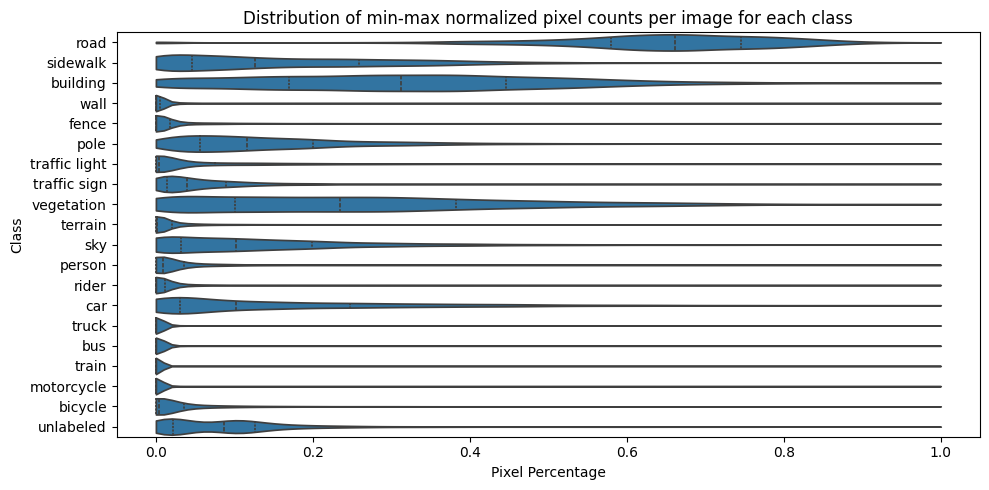

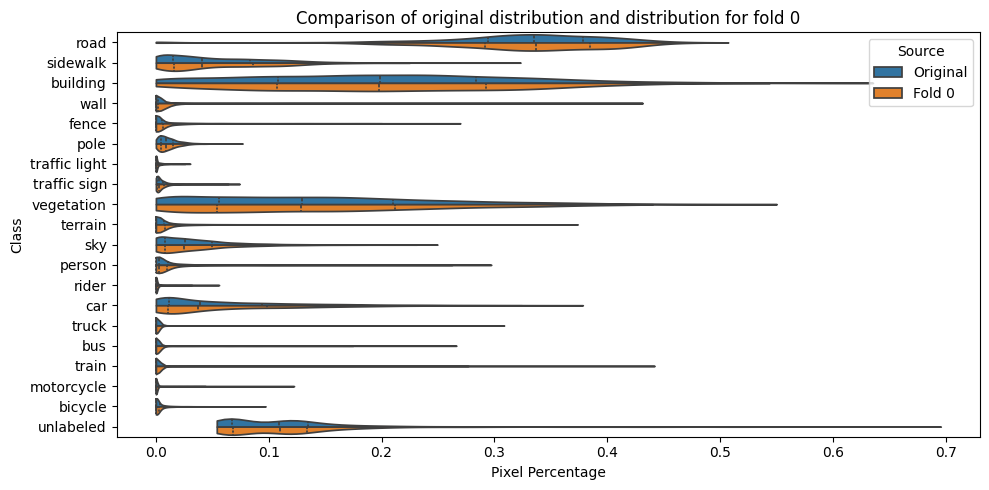

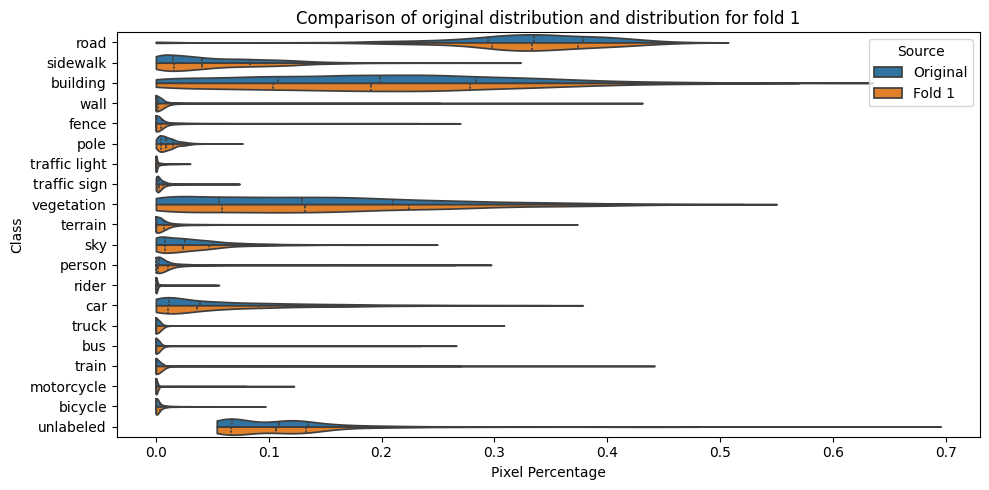

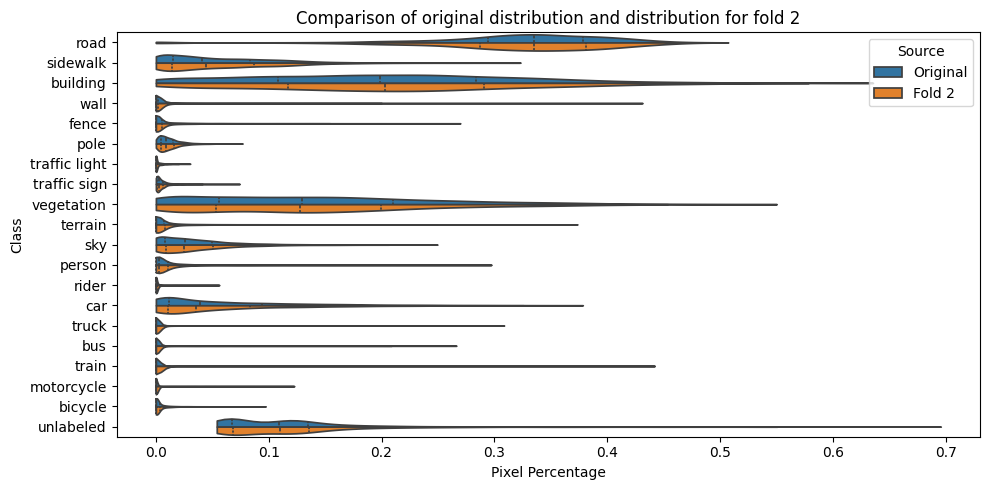

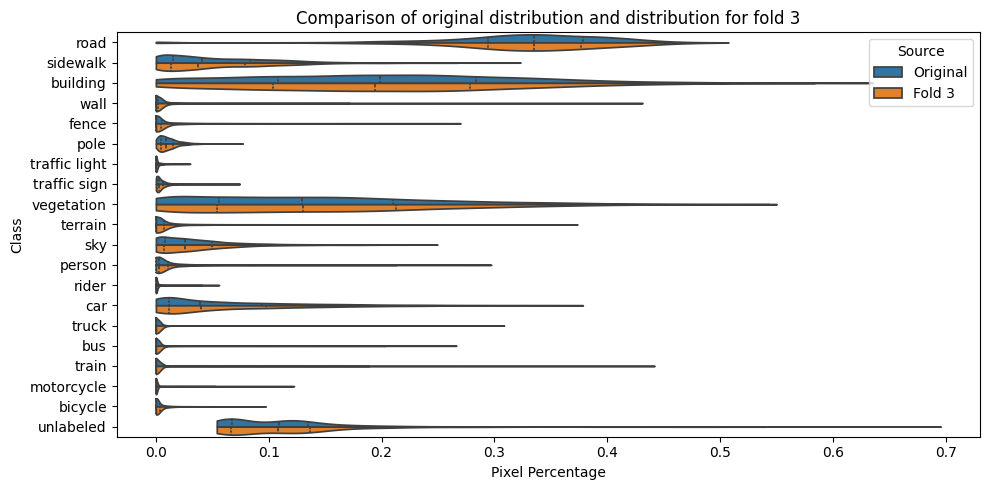

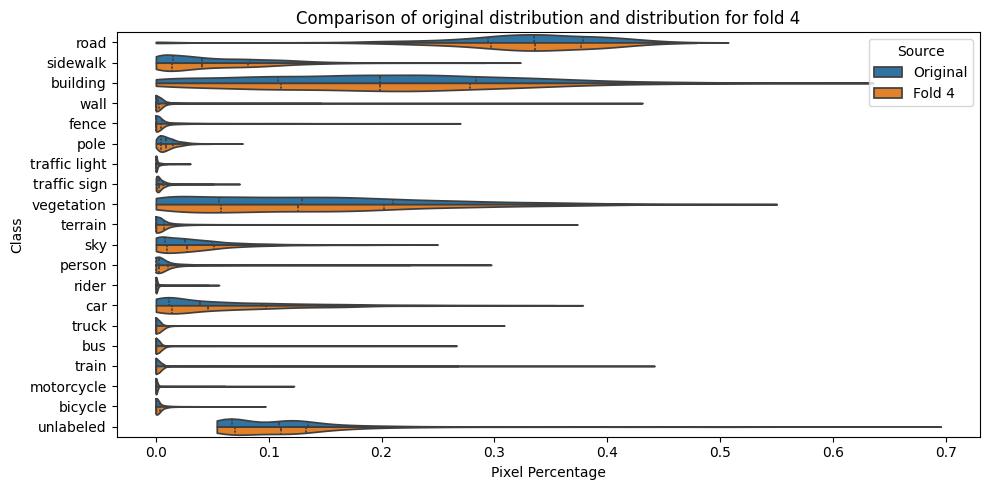

In [3]:
# kit_image_dir = 'KittiDaten/training/image_2'
# kit_annotation_dir = 'KittiDaten/training/semantic'

city_classes = {
    0: 'road',
    1: 'sidewalk',
    2: 'building',
    3: 'wall',
    4: 'fence',
    5: 'pole',
    6: 'traffic light',
    7: 'traffic sign',
    8: 'vegetation',
    9: 'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle',
    19: 'unlabeled',
}

cit_image_dir = 'CityscapesDaten/images'
cit_annotation_dir = 'CityscapesDaten/semantic'

# df = analyse_dataset_GRAY(kit_annotation_dir)
# class_distribution_violin_plot(df)
# stratified_kfold_and_violin_plot(df, k=5)


df2 = analyse_dataset_GRAY(cit_annotation_dir, classes=city_classes)
class_distribution_violin_plot(df2)
stratified_kfold_and_violin_plot(df2,  k=5)

In [4]:
def calculate_class_weights(df):
    # Calculate the total pixel count for each class
    total_pixel_counts = df.groupby('Class')['Pixel Count'].sum()
    
    # Reindex the total_pixel_counts series to match the order of city_classes
    total_pixel_counts = total_pixel_counts.reindex(city_classes.values())


    # Calculate the total pixel count
    total_pixels = total_pixel_counts.sum()

    # Calculate the class weights
    class_weights = total_pixels / (20 * (total_pixel_counts))
    
    # Convert class weights to a PyTorch tensor
    class_weights_tensor = torch.from_numpy(class_weights.values.astype(np.float32))
    
    # Save the tensor to a file
    torch.save(class_weights_tensor, 'CityscapesDaten/class_weights.pt')

    return class_weights, total_pixel_counts


class_weights, total = calculate_class_weights(df2)
sorted_class_weights = class_weights.sort_values(ascending=True)
sorted_total = total.sort_values(ascending=False)

weights_equal_test = class_weights.values *  total.values
arr = np.array(weights_equal_test)
print(np.unique(arr, return_counts=True))

print(class_weights)

(array([3.6438016e+08]), array([20]))
Class
road              0.152993
sidewalk          0.944824
building          0.249295
wall              8.490185
fence             6.509589
pole              4.478882
traffic light    27.426945
traffic sign      9.970298
vegetation        0.350820
terrain           5.090917
sky               1.441691
person            4.598446
rider            38.604672
car               0.816887
truck            20.783080
bus              22.012393
train            26.222695
motorcycle       58.974866
bicycle          12.408356
unlabeled         0.430046
Name: Pixel Count, dtype: float64


In [5]:

class_weights_tensor = torch.load('CityscapesDaten/class_weights.pt')

# Print out the values
print(class_weights_tensor)

tensor([ 0.1530,  0.9448,  0.2493,  8.4902,  6.5096,  4.4789, 27.4269,  9.9703,
         0.3508,  5.0909,  1.4417,  4.5984, 38.6047,  0.8169, 20.7831, 22.0124,
        26.2227, 58.9749, 12.4084,  0.4300])
